# Sprint1 機械学習フロー
## 【問題1】クロスバリデーション
---
事前学習期間は検証データを分割しておき、それに対して指標値を計算することで検証を行っていました。しかし、分割の仕方により精度は変化します。実践的には**クロスバリデーション**を行います。

具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割を行う関数はscikit-learnに<font color='red'>KFold</font>として用意されています。

In [46]:
import pandas as pd

df_home = pd.read_csv("application_train.csv")

df_home

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# 欠損値のデータを確認

# 数値で確認: 欠損値の数と％の表示
num_missing = df_home.isnull().sum().sort_values(ascending = False)
percent = (df_home.isnull().sum()/df_home.isnull().count()*100).sort_values(ascending = False)

home_missing = pd.concat([num_missing, percent], axis=1, keys=['num_missing', 'Percent'])

home_missing[home_missing['num_missing'] > 0]

,num_missing,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
...,...,...
EXT_SOURCE_2,660,0.214626
AMT_GOODS_PRICE,278,0.090403
AMT_ANNUITY,12,0.003902
CNT_FAM_MEMBERS,2,0.000650


In [48]:
# 欠損値が1つでもあれば該当する列を削除する
df = df_home.dropna(axis=1, how="any")
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DO

In [49]:
# 相関関係
df_corr = abs(df.corr()["TARGET"]).sort_values(ascending=False)
df_corr.head(21)

TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
REGION_POPULATION_RELATIVE     0.037227
LIVE_CITY_NOT_WORK_CITY        0.032518
AMT_CREDIT                     0.030369
FLAG_DOCUMENT_6                0.028602
FLAG_WORK_PHONE                0.028524
HOUR_APPR_PROCESS_START        0.024166
FLAG_PHONE                     0.023806
CNT_CHILDREN                   0.019187
FLAG_DOCUMENT_16               0.011615
FLAG_DOCUMENT_13               0.011583
Name: TARGET, dtype: float64

In [50]:
col_name = ['DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','DAYS_ID_PUBLISH',
'REG_CITY_NOT_WORK_CITY','FLAG_EMP_PHONE','DAYS_EMPLOYED','REG_CITY_NOT_LIVE_CITY',
'FLAG_DOCUMENT_3','DAYS_REGISTRATION','REGION_POPULATION_RELATIVE','LIVE_CITY_NOT_WORK_CITY',
'AMT_CREDIT','FLAG_DOCUMENT_6','FLAG_WORK_PHONE','HOUR_APPR_PROCESS_START','FLAG_PHONE',
'CNT_CHILDREN','FLAG_DOCUMENT_16','FLAG_DOCUMENT_13']

# データのサンプルを抽出する
df_sample = df.sample(n=10000, random_state=0)

X = df_sample.loc[:, col_name].values
y = df_sample.loc[:, 'TARGET'].values

# print(X_df.info())
# print(X_df.head())


## 関数

In [51]:
def conver_to_std_scaler(X_train, X_test):
    '''
    標準化する関数
    Paramaeters:
    -------------
    X_train：ndarray型
        説明変数の訓練データ
    X_test：ndarray型
        説明変数の検証データ
    Returns：
    -------------
    X_train_std：ndarray型
        標準化した説明変数の訓練データ
    X_test_std：ndarray型
        標準化した説明変数の検証データ
    '''
    from sklearn.preprocessing import StandardScaler

    # 標準化
    scaler = StandardScaler()
    scaler.fit(X_train) #trainデータのみFitを実行する
    
    return scaler.transform(X_train), scaler.transform(X_test)


In [52]:
def evaluate_performance_model(y_test_data, y_pred_data):
    '''
    検証データと推定したデータからAccuracy, Percision, Recall, F1の指標を計算する関数
    Parameters:
    --------------
        y_test_data : ndarray型
        検証データ
        y_pred_data : ndarray型
        推定データ
    Returns:
    --------------
    None
    '''
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import confusion_matrix
    
    #　推定したデータ
    print("Predict : ", y_pred_data)

    # 4種類の指標を計算する

    # Accuracy（正解率）
    print('Accuracy: \t%.2f' % accuracy_score(y_test_data, y_pred_data))

    # Precision（適合率）
    print('Precision: \t%.2f' % precision_score(y_test_data, y_pred_data))

    # Recall（再現率）
    print('Recall: \t%.2f' % recall_score(y_test_data, y_pred_data))

    # F値
    print('f1: \t\t%.2f' % f1_score(y_test_data, y_pred_data))
    
    # 混合行列
    print('Confusion matrix:\n{}'.format(confusion_matrix(y_test_data, y_pred_data)))

In [53]:
def draw_ROC_curve(y_test, y_pred):
    '''
    検証データと推定したデータからROC曲線のプロットとAUCの値を計算する関数
    Parameters:
    --------------
        y_test : ndarray型
        検証データ
        y_pred : ndarray型
        推定データ
    Returns:
    --------------
    None
    '''
    
    import numpy as np
    from sklearn import metrics
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    print('auc:', auc)

    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.plot(np.linspace(1, 0, len(fpr)), np.linspace(1, 0, len(fpr)), label='Random ROC curve (area = %.2f)'%0.5, linestyle = '--', color = 'gray')

    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

## クロスバリデーション

(train) (8000, 20)
(test) (2000, 20)
-----
Predict: [[0.92650817 0.07349183]
 [0.89508283 0.10491717]
 [0.97448734 0.02551266]
 ...
 [0.9303497  0.0696503 ]
 [0.93265568 0.06734432]
 [0.94395817 0.05604183]]
Predict :  [0 0 0 ... 0 0 0]
Accuracy: 	0.92
Precision: 	0.00
Recall: 	0.00
f1: 		0.00
Confusion matrix:
[[1841    0]
 [ 159    0]]
auc: 0.6512662314369754


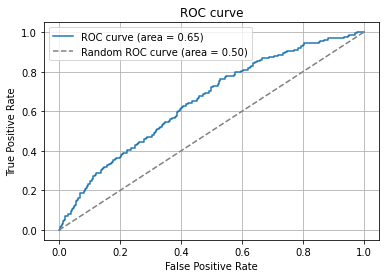

(train) (8000, 20)
(test) (2000, 20)
-----
Predict: [[0.89440334 0.10559666]
 [0.94858456 0.05141544]
 [0.95104119 0.04895881]
 ...
 [0.92441982 0.07558018]
 [0.9529586  0.0470414 ]
 [0.93404375 0.06595625]]
Predict :  [0 0 0 ... 0 0 0]
Accuracy: 	0.93
Precision: 	0.00
Recall: 	0.00
f1: 		0.00
Confusion matrix:
[[1854    0]
 [ 146    0]]
auc: 0.6439279750557846


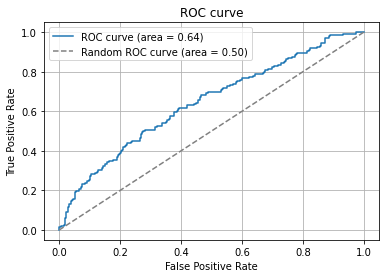

(train) (8000, 20)
(test) (2000, 20)
-----
Predict: [[0.95519588 0.04480412]
 [0.91530457 0.08469543]
 [0.95228624 0.04771376]
 ...
 [0.9300461  0.0699539 ]
 [0.91119475 0.08880525]
 [0.95237339 0.04762661]]
Predict :  [0 0 0 ... 0 0 0]
Accuracy: 	0.92
Precision: 	0.00
Recall: 	0.00
f1: 		0.00
Confusion matrix:
[[1841    0]
 [ 159    0]]
auc: 0.5937332390449543


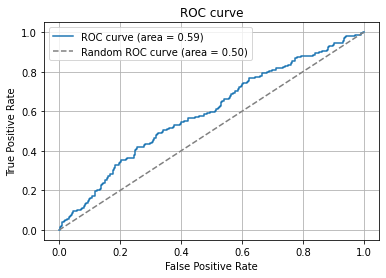

(train) (8000, 20)
(test) (2000, 20)
-----
Predict: [[0.93965115 0.06034885]
 [0.94653545 0.05346455]
 [0.90196257 0.09803743]
 ...
 [0.93181116 0.06818884]
 [0.9458195  0.0541805 ]
 [0.92764365 0.07235635]]
Predict :  [0 0 0 ... 0 0 0]
Accuracy: 	0.92
Precision: 	0.00
Recall: 	0.00
f1: 		0.00
Confusion matrix:
[[1833    0]
 [ 167    0]]
auc: 0.6146169200061417


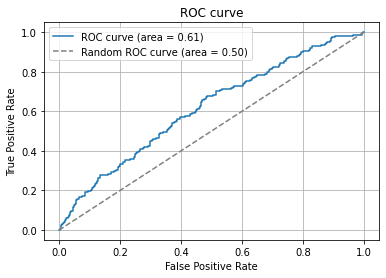

(train) (8000, 20)
(test) (2000, 20)
-----
Predict: [[0.95191639 0.04808361]
 [0.92847969 0.07152031]
 [0.90406015 0.09593985]
 ...
 [0.90774092 0.09225908]
 [0.93764021 0.06235979]
 [0.9271308  0.0728692 ]]
Predict :  [0 0 0 ... 0 0 0]
Accuracy: 	0.93
Precision: 	0.00
Recall: 	0.00
f1: 		0.00
Confusion matrix:
[[1858    0]
 [ 142    0]]
auc: 0.58433269152049


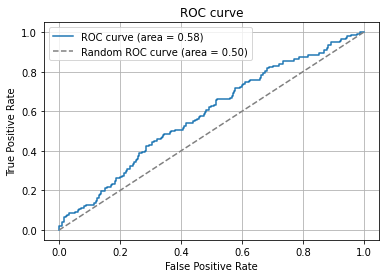

In [66]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# インスタンスの生成、3つの近傍点で投票を行う
# knn_3 = KNeighborsClassifier(n_neighbors=3)
#　インスタンスの生成
lr = LogisticRegression()

for train_idx, test_idx in kf.split(X):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print('(train)', X_train.shape)
    print('(test)', X_test.shape)
    print('-----')
    
    #標準化
    X_train_std, X_test_std = conver_to_std_scaler(X_train, X_test)

    # 学習する
    lr.fit(X_train_std, y_train)

    # 検証データで推定を行う
    y_pred_3 = lr.predict_proba(X_test_std)
    print("Predict: {}".format(y_pred_3))
    
    # 4種類の指標を表示
    evaluate_performance_model(y_test, lr.predict(X_test_std))

    # ROC曲線
    draw_ROC_curve(y_test, y_pred_3[:, 1])



## パイプラインを使用

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

print("----------Logistic Regression-------------")

pipe = Pipeline([("scaler", StandardScaler()),
                  ("lr", LogisticRegression())])

# クロスバリデーション実行
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, scoring='accuracy')
auc = cross_val_score(pipe, X, y, scoring='roc_auc')


print("Accuracy: ", scores)
print("AUC: ", auc)


----------Logistic Regression-------------
Accuracy:  [0.9225 0.9225 0.9225 0.923  0.923 ]
AUC:  [0.60201766 0.61462016 0.63915727 0.59645636 0.62113591]


## 【問題2】グリッドサーチ
---
これまで分類器のパラメータは基本的にデフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになりますが、パラメータは状況に応じて最適なものを選ぶ必要があります。パラメータを探索するために**グリッドサーチ**と呼ばれる総当たり的手法が一般的に利用されます。

グリッドサーチをパイプラインの中に組み込みましょう。

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


print("----------Logistic Regression-------------")

# 訓練データと検証データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# パイプラインでモデルを作成
pipe = Pipeline([("scaler", StandardScaler()),
                 ("pca", PCA()),
                 ("lr", LogisticRegression())])

# 探索するパラメータの設定
params = {
    "pca__n_components": [2, 3, 4],
    "lr__penalty": ["l1", "l2"],
    "lr__C": [10 ** i for i in range(-5, 6)],
    "lr__random_state": [i for i in range(0, 101)]
}

# グリッドサーチ
gs_clf = GridSearchCV(
                        pipe,
                        params,
                        n_jobs=4,
                        cv=5
                    )
gs_clf.fit(X_train, y_train)

# 最適なパラメーター
print(gs_clf.best_params_)

print(classification_report(y_test, gs_clf.predict(X_test)))


----------Logistic Regression-------------
{'lr__C': 1e-05, 'lr__penalty': 'l2', 'lr__random_state': 0, 'pca__n_components': 2}
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2307
           1       0.00      0.00      0.00       193

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500



auc: 0.6011665330341762


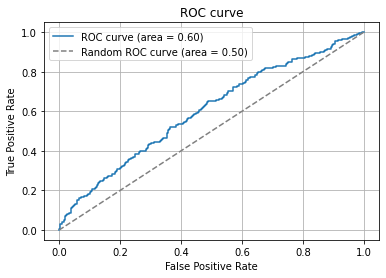

In [69]:
def draw_ROC_curve(y_test, y_pred):
    import numpy as np
    from sklearn import metrics
    import matplotlib.pyplot as plt
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    print('auc:', auc)

    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.plot(np.linspace(1, 0, len(fpr)), np.linspace(1, 0, len(fpr)), label='Random ROC curve (area = %.2f)'%0.5, linestyle = '--', color = 'gray')

    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()
    
draw_ROC_curve(y_test, gs_clf.predict_proba(X_test)[:, 1])

## 【問題3】Kernelからの調査
---
KaggleのKernelから自身にはなかったアイデアを見つけ出して、列挙してください。そして、効果があると考えられるものを検証してください。

#### 1. 欠損値も含めたデータセットの相関関係を見て高い数値のものを抽出し、特徴量として用いる
#### 2. 文字列のデータをLabel EncodingまたはOne Hot Encodingする
#### 3. ドメイン知識で関係する特徴量を計算する

In [38]:
# 相関関係
df_corr = abs(df_home.corr()["TARGET"]).sort_values(ascending=False)
df_corr.head(21)

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
FLOORSMAX_AVG                  0.044003
FLOORSMAX_MEDI                 0.043768
FLOORSMAX_MODE                 0.043226
DAYS_REGISTRATION              0.041975
AMT_GOODS_PRICE                0.039645
OWN_CAR_AGE                    0.037612
REGION_POPULATION_RELATIVE     0.037227
Name: TARGET, dtype: float64

In [39]:

col_name = ['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY',
            'REGION_RATING_CLIENT','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','REG_CITY_NOT_WORK_CITY',
            'FLAG_EMP_PHONE','DAYS_EMPLOYED', 
            'TARGET']

df_extracted = df_home.loc[:, col_name]
df_extracted


,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,DAYS_EMPLOYED,TARGET
0,0.139376,0.262949,0.083037,-9461,2,2,-1134.0,-2120,0,1,-637,1
1,NaN,0.622246,0.311267,-16765,1,1,-828.0,-291,0,1,-1188,0
2,0.729567,0.555912,NaN,-19046,2,2,-815.0,-2531,0,1,-225,0
3,NaN,0.650442,NaN,-19005,2,2,-617.0,-2437,0,1,-3039,0
4,NaN,0.322738,NaN,-19932,2,2,-1106.0,-3458,1,1,-3038,0
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,NaN,0.681632,0.145570,-9327,1,1,-273.0,-1982,0,1,-236,0
307507,NaN,0.115992,NaN,-20775,2,2,0.0,-4090,0,0,365243,0
307508,0.218859,0.535722,0.744026,-14966,3,3,-1909.0,-5150,1,1,-7921,0
307509,0.661024,0.514163,NaN,-11961,2,2,-322.0,-931,1,1,-4786,1


In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_extracted:
    if df_extracted[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_extracted[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_extracted[col])
            # Transform both training and testing data
            df_extracted[col] = le.transform(df_extracted[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)



0 columns were label encoded.


In [41]:
#　ドメイン知識により新しい特徴量を計算する
df_extracted['CREDIT_INCOME_PERCENT'] = df_home['AMT_CREDIT'] / df_home['AMT_INCOME_TOTAL']
df_extracted['ANNUITY_INCOME_PERCENT'] = df_home['AMT_ANNUITY'] / df_home['AMT_INCOME_TOTAL']
df_extracted['CREDIT_TERM'] = df_home['AMT_ANNUITY'] / df_home['AMT_CREDIT']
df_extracted['DAYS_EMPLOYED_PERCENT'] = df_home['DAYS_EMPLOYED'] / df_home['DAYS_BIRTH']

df_extracted

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,DAYS_EMPLOYED,TARGET,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,0.139376,0.262949,0.083037,-9461,2,2,-1134.0,-2120,0,1,-637,1,2.007889,0.121978,0.060749,0.067329
1,NaN,0.622246,0.311267,-16765,1,1,-828.0,-291,0,1,-1188,0,4.790750,0.132217,0.027598,0.070862
2,0.729567,0.555912,NaN,-19046,2,2,-815.0,-2531,0,1,-225,0,2.000000,0.100000,0.050000,0.011814
3,NaN,0.650442,NaN,-19005,2,2,-617.0,-2437,0,1,-3039,0,2.316167,0.219900,0.094941,0.159905
4,NaN,0.322738,NaN,-19932,2,2,-1106.0,-3458,1,1,-3038,0,4.222222,0.179963,0.042623,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,NaN,0.681632,0.145570,-9327,1,1,-273.0,-1982,0,1,-236,0,1.617143,0.174971,0.108198,0.025303
307507,NaN,0.115992,NaN,-20775,2,2,0.0,-4090,0,0,365243,0,3.743750,0.166687,0.044524,-17.580890
307508,0.218859,0.535722,0.744026,-14966,3,3,-1909.0,-5150,1,1,-7921,0,4.429176,0.195941,0.044239,0.529266
307509,0.661024,0.514163,NaN,-11961,2,2,-322.0,-931,1,1,-4786,1,2.164368,0.118158,0.054592,0.400134


In [42]:
# 欠損値があるデータ
df_extracted.isnull().sum()[df_extracted.isnull().sum()>0].sort_values(ascending = False)


EXT_SOURCE_1              173378
EXT_SOURCE_3               60965
EXT_SOURCE_2                 660
ANNUITY_INCOME_PERCENT        12
CREDIT_TERM                   12
DAYS_LAST_PHONE_CHANGE         1
dtype: int64

In [43]:
# 欠損値を平均値に置き換える

df_extracted['EXT_SOURCE_1'] = df_extracted['EXT_SOURCE_1'].fillna(df_extracted['EXT_SOURCE_1'].mean())
df_extracted['EXT_SOURCE_2'] = df_extracted['EXT_SOURCE_2'].fillna(df_extracted['EXT_SOURCE_2'].mean())
df_extracted['EXT_SOURCE_3'] = df_extracted['EXT_SOURCE_3'].fillna(df_extracted['EXT_SOURCE_3'].mean())
df_extracted['DAYS_LAST_PHONE_CHANGE'] = df_extracted['DAYS_LAST_PHONE_CHANGE'].fillna(df_extracted['DAYS_LAST_PHONE_CHANGE'].mean())
df_extracted['ANNUITY_INCOME_PERCENT'] = df_extracted['ANNUITY_INCOME_PERCENT'].fillna(df_extracted['ANNUITY_INCOME_PERCENT'].mean())
df_extracted['CREDIT_TERM'] = df_extracted['CREDIT_TERM'].fillna(df_extracted['CREDIT_TERM'].mean())

df_extracted.isnull().sum()[df_extracted.isnull().sum()>0].sort_values(ascending = False)

Series([], dtype: int64)

In [44]:
# データのサンプルを抽出する
df_sample = df_extracted.sample(n=10000, random_state=0)

X = df_sample.drop(columns = ['TARGET']).values
y = df_sample.loc[:, 'TARGET'].values

print(X.shape)
print(y.shape)

(10000, 15)
(10000,)


----------Logistic Regression-------------
Best parameters: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__random_state': 0, 'pca__n_components': 4}
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2307
           1       0.00      0.00      0.00       193

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500

auc: 0.7183835634282685


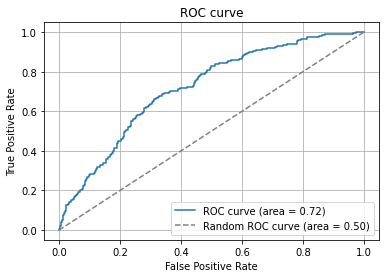

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


print("----------Logistic Regression-------------")

# 訓練データと検証データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# パイプラインでモデルを作成
pipe = Pipeline([("scaler", StandardScaler()),
                 ("pca", PCA()),
                 ("lr", LogisticRegression())])

# 探索するパラメータの設定
params = {
    "pca__n_components": [2, 3, 4],
    "lr__penalty": ["l1", "l2"],
    "lr__C": [10 ** i for i in range(-5, 6)],
    "lr__random_state": [i for i in range(0, 101)]
}

# グリッドサーチ
gs_clf = GridSearchCV(
                        pipe,
                        params,
                        n_jobs=4,
                        cv=5
                    )
gs_clf.fit(X_train, y_train)


# 最適なパラメーター
print("Best parameters:", gs_clf.best_params_)

# 精度のマトリックス
print(classification_report(y_test, gs_clf.predict(X_test)))

# aucの値と可視化
draw_ROC_curve(y_test, gs_clf.predict_proba(X_test)[:, 1])

## 【問題4】高い汎化性能のモデル
---
これまで学んだことを用いながら汎化性能の高いモデルを作成してください。今は全体の流れを掴むことを重視し、Sprintの時間内に結果を出すということも意識しましょう。

## 　複数の分類器をグリッドサーチで実施
---
### << ランダムフォレスト >>

----------Random Forest-------------
Best parameters: {'pca__n_components': 4, 'rfc__criterion': 'entropy', 'rfc__n_estimators': 80, 'rfc__random_state': 12}
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2307
           1       0.33      0.01      0.01       193

    accuracy                           0.92      2500
   macro avg       0.63      0.50      0.48      2500
weighted avg       0.88      0.92      0.89      2500

auc: 0.6398065360886331


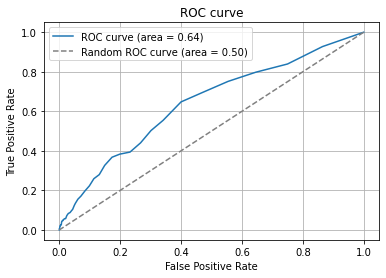

In [165]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

print("----------Random Forest-------------")

# 訓練データと検証データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# パイプラインでモデルを作成
pipe = Pipeline([("scaler", StandardScaler()),
                 ("pca", PCA()),
                 ("rfc", RandomForestClassifier())])

# 探索するパラメータの設定
params = {
    "pca__n_components": [2, 3, 4],
#     "rfc__n_estimators": [i for i in range(1, 21)],
    "rfc__n_estimators": [1, 10, 20, 40, 60, 80, 100],
    "rfc__criterion": ["gini", "entropy"],
    "rfc__random_state": [i for i in range(0, 101)]
}

# グリッドサーチ
gs_clf = GridSearchCV(
                        pipe,
                        params,
                        cv=5
                    )
gs_clf.fit(X_train, y_train)


# 最適なパラメーター
print("Best parameters:", gs_clf.best_params_)

# 精度のマトリックス
print(classification_report(y_test, gs_clf.predict(X_test)))

# aucの値と可視化
draw_ROC_curve(y_test, gs_clf.predict_proba(X_test)[:, 1])

### << SVM >>

----------SVM-------------
Best parameters: {'pca__n_components': 2, 'svc__C': 0.1, 'svc__kernel': 'linear', 'svc__random_state': 0}
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2307
           1       0.00      0.00      0.00       193

    accuracy                           0.92      2500
   macro avg       0.46      0.50      0.48      2500
weighted avg       0.85      0.92      0.89      2500

auc: 0.638693680643053


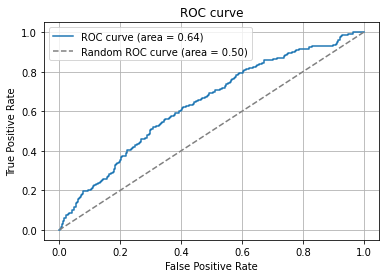

In [33]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

print("----------SVM-------------")

# 訓練データと検証データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# パイプラインでモデルを作成
pipe = Pipeline([("scaler", StandardScaler()),
                 ("pca", PCA()),
                 ("svc", SVC(probability=True))])
            
# 探索するパラメータの設定
params = {
    "pca__n_components": [2, 3, 4],
    "svc__kernel": ["linear"],
    "svc__C": [0.1, 1, 10],
    "svc__random_state": [i for i in range(0, 101)]
}

# グリッドサーチ
gs_clf = GridSearchCV(
                        pipe,
                        params,
                        n_jobs=4,
                        cv=5
                    )
gs_clf.fit(X_train, y_train)


# 最適なパラメーター
print("Best parameters:", gs_clf.best_params_)

# 精度のマトリックス
print(classification_report(y_test, gs_clf.predict(X_test)))

# aucの値と可視化
draw_ROC_curve(y_test, gs_clf.predict_proba(X_test)[:, 1])

## 検証結果

複数の分類器モデルで検証を行った結果、ロジステック回帰モデルが0.72と最も汎化性能が高かった。